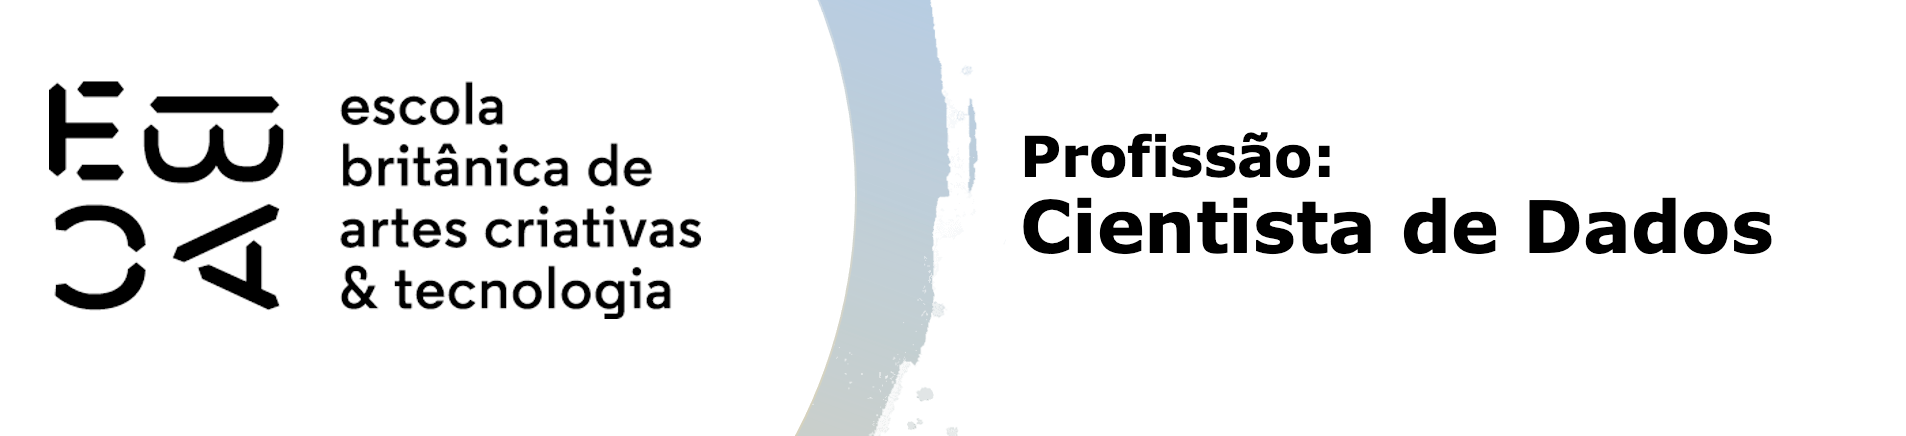

# Tarefa

Carregue a base ```NFP.ftr```. Essa base é proveniente do projeto #AMABiliDados, e contém dados da nota fiscal paulista cadastrados para doação automática para a AMA, Associação de Amigos do Autista. 

A *Nota Fiscal Paulista* é um programa de incentivo do governo do estado de São Paulo, que retorna um pedacinho do ICMS ao consumidor sempre que solicita o registro do seu CPF na nota. Nesse programa, o contribuinte pode direcionar seus créditos a uma ONG, e quando faz isso, sempre que faz esse consumidor cadastrado faz uma compra, os créditos de notas emitidas pelo mesmo estabelecimento não identificadas (notas sem CPF) são "arrastados" para a ONG na forma de uma doação.

Clique no link, caso queira saber mais sobre a [AMA](https://www.ama.org.br/site/).<br>
Clique no link, caso queira saber como o cidadão pode ser um [doador da NFP](https://doacao1.ama.org.br/sitenfp).

Essa base possui dados das notas cujos contribuintes direcionaram seus créditos à AMA. Seus campos estão descritos abaixo:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_pickle('base_nfp.pkl')
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


## Análise da probabilidade de retorno

Considere somente os dados de janeiro de 2020 em diante para esta análise.

- Analise a proporção de notas que tiveram retorno>0 por categoria de estabelecimento. Esta análise pode ser por tabela ou gráfico.

      categoria  proporcao_retorno_positivo
5  Restaurantes                    0.746214
0     Alimentos                    0.681584
4       Mercado                    0.478155
2    Construção                    0.468810
8  não definido                    0.363394
3      Farmácia                    0.351556
1    Auto posto                    0.250000
7     Vestuário                    0.230729
6        Varejo                    0.138373


<Figure size 1200x600 with 0 Axes>

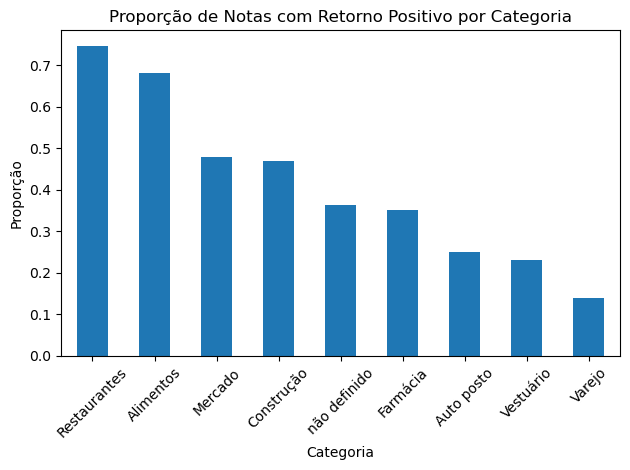

In [2]:
# Filtrando os dados a partir de janeiro de 2020
df_2020 = df[df['Data Emissão'] >= '2020-01-01']

# Agrupando os dados por categoria e calculando a proporção de notas com retorno positivo
grouped = df_2020.groupby('categoria').apply(lambda x: sum(x['Retorno'] > 0) / len(x)).reset_index()
grouped.columns = ['categoria', 'proporcao_retorno_positivo']

# Ordenando os resultados
grouped = grouped.sort_values(by='proporcao_retorno_positivo', ascending=False)

# Apresentando os resultados
print(grouped)

# Criando um gráfico de barras para visualizar os resultados
plt.figure(figsize=(12,6))
grouped.plot(x='categoria', y='proporcao_retorno_positivo', kind='bar', legend=False)
plt.title('Proporção de Notas com Retorno Positivo por Categoria')
plt.ylabel('Proporção')
plt.xlabel('Categoria')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Uma breve análise dos resultados:

A categoria "Restaurantes" tem a maior proporção de notas com retorno positivo, com aproximadamente 74,6%. Isso pode indicar que a maioria das transações nessa categoria são elegíveis para receber créditos do programa Nota Fiscal Paulista.

A categoria "Alimentos" também apresenta uma alta proporção, com cerca de 68,2%.

As categorias "Mercado" e "Construção" seguem com proporções de 47,8% e 46,9%, respectivamente.

No final, a categoria "Varejo" possui a menor proporção de notas com retorno positivo, com apenas 13,8%.

## Cálculo do WOE

- Calcule o WOE das categorias, sendo que o evento em questão é a nota ter retorno>0.
- Analise este WOE por tabela e por gráfico.

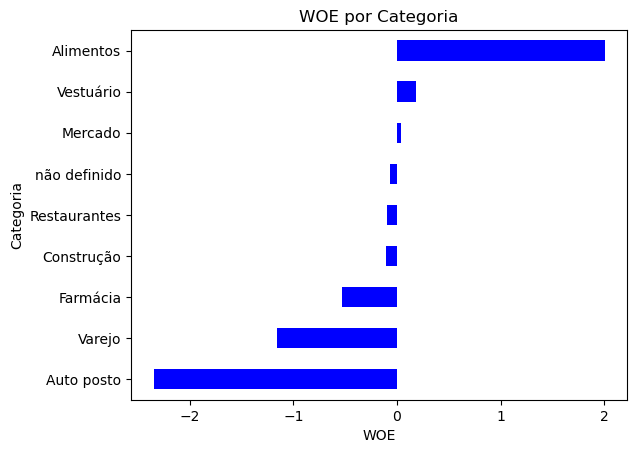

In [6]:
# Filtrando os dados para calcular proporções
eventos = df[df['Retorno'] > 0].groupby('categoria').size()
nao_eventos = df[df['Retorno'] <= 0].groupby('categoria').size()

# Calculando proporções para o evento e não-evento
prop_evento = eventos / eventos.sum()
prop_nao_evento = nao_eventos / nao_eventos.sum()

# Calculando WOE para cada categoria
woe = np.log(prop_evento / prop_nao_evento)

# Plotando o WOE
woe.sort_values().plot(kind='barh', color='blue', title='WOE por Categoria')
plt.xlabel('WOE')
plt.ylabel('Categoria')
plt.show()

**Alimentos:** Esta categoria apresenta o maior WOE positivo. Em comparação com as demais categorias, "Alimentos" tem uma forte associação com um retorno positivo. Isso significa que as notas na categoria "Alimentos" têm uma probabilidade relativamente alta de ter um retorno maior que zero.

**Vestuário, Mercado,** ***não definido***, **Restaurantes:** Estas categorias possuem WOE positivos, mas não tão altos quanto "Alimentos". Ainda assim, indica uma associação favorável com retornos positivos.

**Construção, Farmácia:** Estas categorias possuem WOE próximos de zero, o que sugere que elas não têm uma forte associação nem com retornos positivos nem com retornos negativos.

**Varejo, Auto posto:** Estas categorias têm WOEs negativos, com "Auto posto" tendo o valor mais negativo. Isso indica uma associação inversa com retornos positivos. Ou seja, as notas nessas categorias têm uma probabilidade relativamente baixa de ter um retorno maior que zero.

## Cálculo do *Information Value*

Calcule o *IV* dessa variável.

In [10]:
# Suponhamos que seu dataframe se chame df
df_grouped = df.groupby('categoria').agg({'flag_credito': ['sum', 'count']})
df_grouped.columns = ['Bons', 'Total']

df_grouped['Maus'] = df_grouped['Total'] - df_grouped['Bons']
df_grouped['prop_bons'] = df_grouped['Bons'] / df['flag_credito'].sum()
df_grouped['prop_maus'] = df_grouped['Maus'] / (df.shape[0] - df['flag_credito'].sum())
df_grouped['WoE'] = np.log(df_grouped['prop_bons'] / df_grouped['prop_maus'])
df_grouped['diff'] = df_grouped['prop_bons'] - df_grouped['prop_maus']
df_grouped['IV_categoria'] = df_grouped['diff'] * df_grouped['WoE']

IV_total = df_grouped['IV_categoria'].sum()
df_grouped

,Bons,Total,Maus,prop_bons,prop_maus,WoE,diff,IV_categoria
categoria,,,,,,,,
Alimentos,12868,14960,2092,0.152036,0.020309,2.013046,0.131727,0.265172
Auto posto,271,3689,3418,0.003202,0.033182,-2.338269,-0.029980,0.070101
Construção,13811,32236,18425,0.163177,0.178870,-0.091820,-0.015692,0.001441
Farmácia,4886,14940,10054,0.057728,0.097604,-0.525173,-0.039876,0.020942
Mercado,19808,42695,22887,0.234032,0.222187,0.051940,0.011845,0.000615
Restaurantes,17118,39749,22631,0.202250,0.219701,-0.082767,-0.017452,0.001444
Varejo,1035,5904,4869,0.012229,0.047268,-1.352064,-0.035040,0.047376
Vestuário,1799,3612,1813,0.021255,0.017601,0.188671,0.003655,0.000690
não definido,13042,29861,16819,0.154092,0.163279,-0.057911,-0.009187,0.000532


## Conclua

Não se esqueça de registrar suas conclusões em uma célula de texto. <font color='red'>**Sugestão:**</font> tente alterar a cor da fonte nesta célula para diferenciá-la das demais.


<div style="background-color: #e6f7ff; padding: 10px; border-radius: 5px;">

**Alimentos** parece ser a categoria mais promissora em termos de previsão, com uma alta proporção de bons resultados e o maior valor IV.

**Auto posto** e **Varejo** têm WoEs negativos significativos, indicando uma maior propensão para resultados negativos.

Em geral, o IV nos dá uma noção do poder preditivo de cada categoria. Neste caso, **Alimentos** e **Auto posto** se destacam como as categorias mais informativas.

</div>